In [1]:
# imports

# python standard libraries
import os
import random

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf

import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.8.0
keras.__version__: 2.8.0


In [2]:
data_dir = '../data/training_data/training_data'
file_list = os.listdir(data_dir)

In [3]:
df = pd.read_csv('../data/training_norm.csv')
df.head()

,image_id,angle,speed
0,1,0.4375,0.0000
1,2,0.8125,1.0000
2,3,0.4375,1.0000
3,4,0.6250,1.0000
4,5,0.5000,0.0000


In [4]:
image_id = []
image_name = []
image_path = []
image_array = []
file_size = []
for filename in file_list:
    im = cv2.imread(data_dir + '/' + filename)
    image_name.append(filename)
    image_array.append(im)
    image_path.append(data_dir + '/' + filename)
    file_size.append(os.path.getsize(data_dir + '/' + filename))
    image_id.append(int(filename.split('.')[0]))

In [5]:
data = {
    'image_id': image_id,
    'image_name': image_name,
    'image': image_array,
    'image_path': image_path,
    'file_size': file_size
}

In [6]:
new_df = pd.DataFrame(data)
new_df.head()

,image_id,image_name,image,image_path,file_size
0,1,1.png,"[[[134, 135, 139], [134, 135, 139], [136, 139, 139], [136, 139, 139], [126, 140, 144], [128, 142, 147], [136, 143, 149], [139, 146, 151], [147, 157, 153], [147, 157, 153], [140, 145, 156], [134, 1...",../data/training_data/training_data/1.png,128113
1,10,10.png,"[[[14, 13, 16], [13, 12, 14], [11, 13, 13], [11, 13, 13], [11, 14, 11], [10, 13, 10], [11, 13, 13], [11, 13, 13], [11, 13, 13], [11, 13, 13], [10, 13, 10], [10, 13, 10], [10, 12, 12], [11, 13, 13]...",../data/training_data/training_data/10.png,122343
2,100,100.png,"[[[57, 68, 64], [58, 69, 65], [62, 67, 66], [62, 67, 66], [58, 70, 63], [61, 72, 65], [53, 72, 64], [53, 72, 64], [65, 69, 66], [64, 68, 65], [59, 67, 71], [61, 69, 72], [62, 71, 71], [59, 68, 69]...",../data/training_data/training_data/100.png,123855
3,1000,1000.png,"[[[123, 125, 125], [123, 125, 125], [115, 125, 123], [118, 127, 126], [117, 128, 128], [116, 127, 127], [117, 127, 130], [118, 128, 131], [126, 127, 131], [128, 129, 134], [125, 125, 132], [125, 1...",../data/training_data/training_data/1000.png,122253
4,10000,10000.png,"[[[6, 5, 7], [6, 5, 7], [5, 5, 5], [7, 7, 7], [9, 11, 6], [15, 17, 12], [19, 22, 19], [22, 26, 23], [28, 25, 26], [28, 25, 26], [32, 24, 26], [32, 24, 26], [26, 25, 23], [24, 23, 21], [16, 15, 19]...",../data/training_data/training_data/10000.png,125490


In [7]:
merged_df = pd.merge(df, new_df, how='left', on='image_id')
merged_df.head()

,image_id,angle,speed,image_name,image,image_path,file_size
0,1,0.4375,0.0000,1.png,"[[[134, 135, 139], [134, 135, 139], [136, 139, 139], [136, 139, 139], [126, 140, 144], [128, 142, 147], [136, 143, 149], [139, 146, 151], [147, 157, 153], [147, 157, 153], [140, 145, 156], [134, 1...",../data/training_data/training_data/1.png,128113
1,2,0.8125,1.0000,2.png,"[[[160, 144, 142], [155, 140, 138], [156, 136, 128], [165, 144, 136], [109, 113, 103], [106, 109, 100], [108, 109, 107], [113, 114, 111], [120, 114, 120], [124, 117, 123], [128, 122, 114], [129, 1...",../data/training_data/training_data/2.png,127064
2,3,0.4375,1.0000,3.png,"[[[65, 40, 60], [66, 41, 61], [63, 53, 55], [69, 59, 61], [61, 57, 67], [65, 62, 72], [80, 64, 66], [80, 64, 66], [77, 67, 69], [12, 2, 3], [59, 63, 53], [255, 255, 249], [255, 255, 255], [255, 25...",../data/training_data/training_data/3.png,126239
3,4,0.6250,1.0000,4.png,"[[[16, 12, 8], [5, 2, 0], [80, 64, 65], [135, 119, 119], [128, 108, 102], [128, 108, 102], [132, 110, 100], [133, 111, 101], [128, 111, 100], [126, 110, 99], [124, 110, 99], [126, 111, 100], [126,...",../data/training_data/training_data/4.png,113880
4,5,0.5000,0.0000,5.png,"[[[189, 163, 165], [190, 164, 166], [203, 170, 164], [218, 186, 179], [196, 172, 167], [194, 171, 166], [194, 175, 158], [194, 175, 158], [192, 169, 171], [197, 174, 175], [201, 176, 169], [201, 1...",../data/training_data/training_data/5.png,125944


In [9]:
cleaned_df = merged_df[merged_df['file_size'] > 0]
cleaned_df['speed'] = cleaned_df['speed'].astype(np.int32)
cleaned_df.head()

,image_id,angle,speed,image_name,image,image_path,file_size
0,1,0.4375,0,1.png,"[[[134, 135, 139], [134, 135, 139], [136, 139, 139], [136, 139, 139], [126, 140, 144], [128, 142, 147], [136, 143, 149], [139, 146, 151], [147, 157, 153], [147, 157, 153], [140, 145, 156], [134, 1...",../data/training_data/training_data/1.png,128113
1,2,0.8125,1,2.png,"[[[160, 144, 142], [155, 140, 138], [156, 136, 128], [165, 144, 136], [109, 113, 103], [106, 109, 100], [108, 109, 107], [113, 114, 111], [120, 114, 120], [124, 117, 123], [128, 122, 114], [129, 1...",../data/training_data/training_data/2.png,127064
2,3,0.4375,1,3.png,"[[[65, 40, 60], [66, 41, 61], [63, 53, 55], [69, 59, 61], [61, 57, 67], [65, 62, 72], [80, 64, 66], [80, 64, 66], [77, 67, 69], [12, 2, 3], [59, 63, 53], [255, 255, 249], [255, 255, 255], [255, 25...",../data/training_data/training_data/3.png,126239
3,4,0.6250,1,4.png,"[[[16, 12, 8], [5, 2, 0], [80, 64, 65], [135, 119, 119], [128, 108, 102], [128, 108, 102], [132, 110, 100], [133, 111, 101], [128, 111, 100], [126, 110, 99], [124, 110, 99], [126, 111, 100], [126,...",../data/training_data/training_data/4.png,113880
4,5,0.5000,0,5.png,"[[[189, 163, 165], [190, 164, 166], [203, 170, 164], [218, 186, 179], [196, 172, 167], [194, 171, 166], [194, 175, 158], [194, 175, 158], [192, 169, 171], [197, 174, 175], [201, 176, 169], [201, 1...",../data/training_data/training_data/5.png,125944


image_path: ../data/training_data/training_data/22.png
steering_Angle: 0.312500
speed: 0


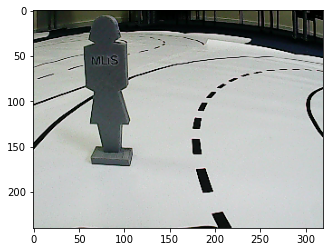

In [11]:
image_index = 21
plt.imshow(Image.open(cleaned_df['image_path'][image_index]))
print("image_path: %s" % cleaned_df['image_path'][image_index])
print("steering_Angle: %f" % cleaned_df['angle'][image_index])
print("speed: %d" % cleaned_df['speed'][image_index])

(array([3390.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        10403.0000]),
 array([0.0000, 0.0400, 0.0800, 0.1200, 0.1600, 0.2000, 0.2400, 0.2800,
        0.3200, 0.3600, 0.4000, 0.4400, 0.4800, 0.5200, 0.5600, 0.6000,
        0.6400, 0.6800, 0.7200, 0.7600, 0.8000, 0.8400, 0.8800, 0.9200,
        0.9600, 1.0000]),
 <BarContainer object of 25 artists>)

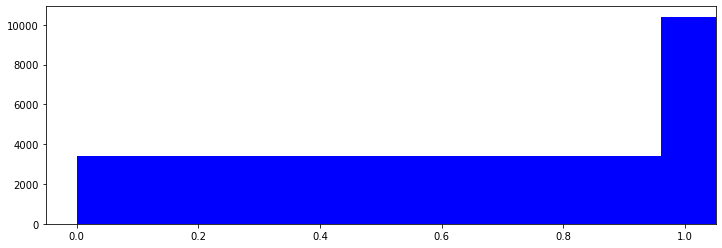

In [13]:
# Look at the distribution of speed
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(cleaned_df['speed'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(cleaned_df['speed'], bins=num_of_bins, width=1, color='blue')

Training data: 8275
Validation data: 5518


Text(0.5, 1.0, 'Validation Data')

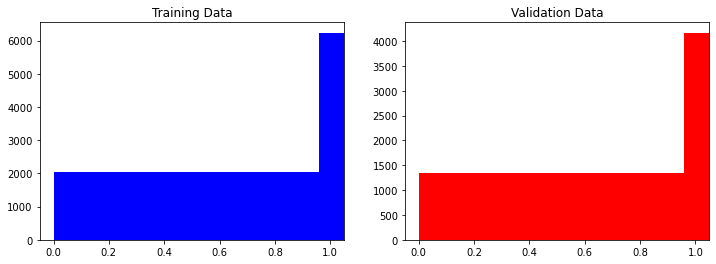

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df['image_path'].to_list(), cleaned_df['speed'].to_list(), test_size=0.4)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

In [15]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

Text(0.5, 1.0, 'processed')

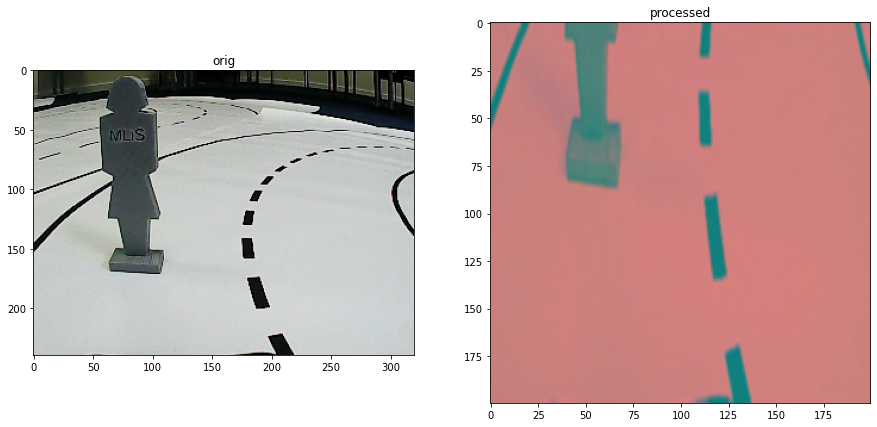

In [40]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,200)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(cleaned_df['image_path'][image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [41]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

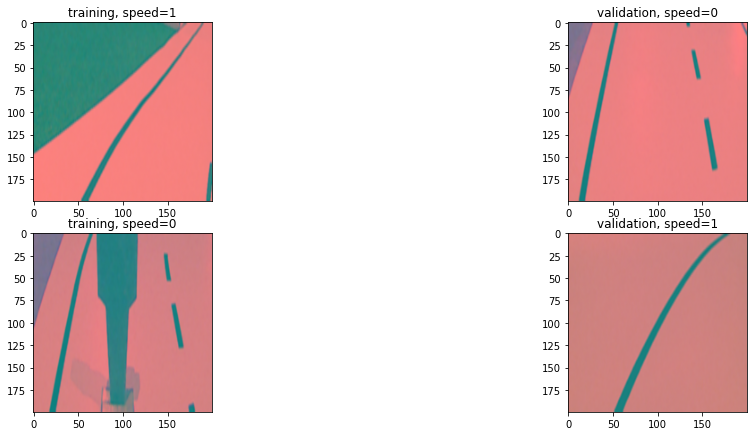

In [42]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, speed=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, speed=%s" % y_valid_batch[i])

In [45]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    model.add(tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, weights="imagenet", input_shape=(200, 200, 3)))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'sigmoid'))
    model.layers[0].trainable = False

    model.compile(optimizer=tf.optimizers.RMSprop(lr=0.01), loss='binary_crossentropy', metrics='accuracy')

    return model

In [46]:
model = nvidia_model()
model.summary()

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [54]:
model_output_dir = '../models/speed'

# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs'
#!rm -rf $log_dir_root

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir_root, histogram_freq=1)

# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'),
    verbose=1,
    save_best_only=True
)

In [55]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [56]:
os.makedirs(log_dir_root, exist_ok=True)
%tensorboard --logdir {log_dir_root}

In [57]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir ../models/speed/logs (started 0:00:00 ago; pid 1992)
  - port 6006: logdir ../models/angle/logs (started 1:01:15 ago; pid 368)
  - port 6006: logdir ../models/angle/logs/ (started 1:04:15 ago; pid 4892)


In [58]:
'''
Connect to the below link.
http://localhost:port
'''

'\nConnect to the below link.\nhttp://localhost:port\n'

In [59]:
import tensorboard

In [60]:
history = model.fit(
    image_data_generator(X_train, y_train, batch_size=200),
    steps_per_epoch=500,
    epochs=10,
    validation_data = image_data_generator(X_valid, y_valid, batch_size=200),
    validation_steps=200,
    verbose=1,
    shuffle=1,
    callbacks=[checkpoint_callback, tensorboard_callback]
)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9277
Epoch 1: val_loss improved from inf to 0.17169, saving model to ../models/speed\lane_navigation_check.h5
500/500 [==============================] - 1716s 3s/step - loss: 0.2220 - accuracy: 0.9277 - val_loss: 0.1717 - val_accuracy: 0.9398
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9472
Epoch 2: val_loss did not improve from 0.17169
500/500 [==============================] - 2134s 4s/step - loss: 0.1583 - accuracy: 0.9472 - val_loss: 0.3490 - val_accuracy: 0.9250
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.1394 - accuracy: 0.9528
Epoch 3: val_loss did not improve from 0.17169
500/500 [==============================] - 1355s 3s/step - loss: 0.1394 - accuracy: 0.9528 - val_loss: 0.1755 - val_accuracy: 0.9382
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9569
Epoch 4: val_loss 

KeyboardInterrupt: 

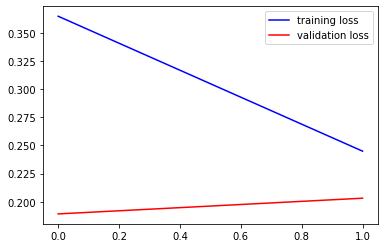

In [61]:
history
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [62]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 0.036
r_squared = 74.33%



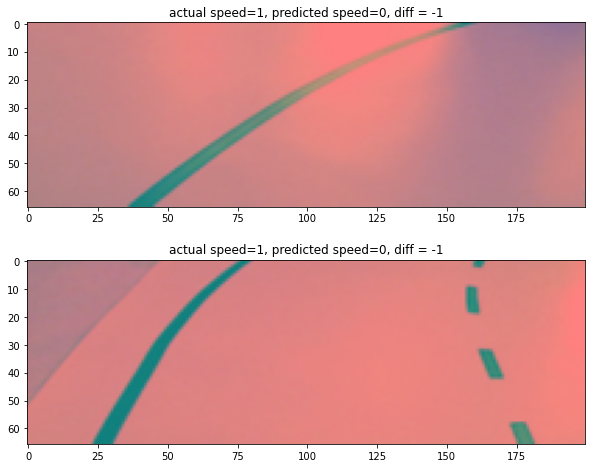

In [ ]:
n_tests = 500
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual speed={y_test[i]}, predicted speed={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")

In [ ]:
'''
Epoch 1/2
500/500 [==============================] - ETA: 0s - loss: 0.3647 - accuracy: 0.8987
Epoch 1: val_loss improved from inf to 0.18914, saving model to ../models/angle\lane_navigation_check.h5
500/500 [==============================] - 507s 1s/step - loss: 0.3647 - accuracy: 0.8987 - val_loss: 0.1891 - val_accuracy: 0.9424
Epoch 2/2
472/500 [===========================>..] - ETA: 19s - loss: 0.2467 - accuracy: 0.9299
'''